### <span style="color:#f1c232">Environment</span>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.CodeMirror pre {font-size: 10pt; font-weight:normal}</style>"))

/var/folders/zp/btn0mxqs6p5gkc_pr91hcp2m0000gn/T/ipykernel_67700/1371838347.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from sqlalchemy import create_engine, inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import sqlite3
from scipy.stats import norm

In [5]:
# Create engine to connect to the db
engine = create_engine('sqlite:///../Data/trading_database.db', echo=False)
inspector = inspect(engine)
schemas = inspector.get_schema_names()

# Find schemas and tables in the db
for schema in schemas:
    print("schema: %s" % schema)
    for table_name in inspector.get_table_names(schema=schema):
        print(table_name)
        for column in inspector.get_columns(table_name, schema=schema):
            print("Column: %s" % column)

schema: main
position
Column: {'name': 'index', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'Instrument', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'Total Position', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'Volatility(%)', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
stocks
Column: {'name': 'Stock', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'stock_id', 'type': INTEGER(), 'nullable': True, 'default': None, 'primary_key': 0}
trades
Column: {'name': 'index', 'type': INTEGER(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'Time', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'BUY_SELL_FLAG', 'type': INTEGER(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'PRICE', 'type': REAL(), 'nullable': True, 'd

In [6]:
# Example query
df = pd.read_sql("select * from trades", engine)
df

,index,Time,BUY_SELL_FLAG,PRICE,SIZE,stock_id
0,124,01-01-2017 09:02,1,82.06,25,3
1,125,01-01-2017 09:02,0,82.02,30,3
2,126,01-01-2017 09:02,0,82.01,160,3
3,127,01-01-2017 09:02,0,82.01,40,3
4,128,01-01-2017 09:02,0,82.00,80,3
...,...,...,...,...,...,...
39408,39367,02-01-2017 17:29,1,90.86,280,0
39409,39372,02-01-2017 17:29,1,90.86,26,0
39410,39373,02-01-2017 17:29,1,90.86,1,0
39411,39392,02-01-2017 17:29,1,90.87,92,0


### <span style="color:#f1c232">Q1</span>

Defining a basic fuction to get the tables when they are needed.

In [7]:
def get_table(table):
    return pd.read_sql(f"select * from  {table}", engine)
#def get_stocks():
#def get_position():

In [8]:
df_position = get_table(table='position')
print(df_position.head())
df_trades = get_table(table='trades')
print(df_trades.head())
df_stocks = get_table(table='stocks')
print(df_stocks.head())


   index          Instrument  Total Position  Volatility(%)
0      0  INN C2017070012000           -3077             24
1      1  INN C2017070012500            2911             32
2      2  INN C2017070013000            6862             17
3      3  INN C2017070013500            -110             33
4      4  INN C2017070014000            7888             16
   index              Time  BUY_SELL_FLAG  PRICE  SIZE  stock_id
0    124  01-01-2017 09:02              1  82.06    25         3
1    125  01-01-2017 09:02              0  82.02    30         3
2    126  01-01-2017 09:02              0  82.01   160         3
3    127  01-01-2017 09:02              0  82.01    40         3
4    128  01-01-2017 09:02              0  82.00    80         3
  Stock  stock_id
0   SAP         0
1   DAI         1
2   DTE         2
3   BAS         3


### <span style="color:#f1c232">Q2</span>

Aggregating on stock_id to calculate the price statistics for each.

In [9]:
q2 = (
"select "
"stock_id, "
"COUNT() as Number_of_trades, "
"AVG(PRICE) as Average_traded_price, "
"AVG(PRICE*size)/AVG(size) as Volume_weighted_average_traded_price,"
"AVG(PRICE*size*BUY_SELL_FLAG)/AVG(size*BUY_SELL_FLAG) as Volume_weighted_average_buy_price ,"
"AVG(PRICE*size*(BUY_SELL_FLAG-1))/AVG(size*(BUY_SELL_FLAG-1)) as Volume_weighted_average_sell_price "
"from trades group by stock_id"
)
pd.read_sql(q2, engine)

,stock_id,Number_of_trades,Average_traded_price,Volume_weighted_average_traded_price,Volume_weighted_average_buy_price,Volume_weighted_average_sell_price
0,0,10657,91.104291,91.029036,90.985340,91.080451
1,1,8913,64.119086,64.125512,64.131767,64.116157
2,2,7044,15.743776,15.728003,15.715737,15.743700
3,3,9696,82.285728,82.320935,82.324108,82.315720
4,4,3103,179.457316,179.406573,179.473252,179.334588


### <span style="color:#f1c232">Q3</span>

Aggregating on stock_id to calculate the volume statistics for each.
The expression 'Using the “stocks” table to map the stocks to trades' essentially makes me think that it should be left join, so that only stocks from table "Stocks" will be examined, though I chose to go with full join to see whether any unknown stock_id's exist. <br>
<br>
SQL:

In [10]:
q3 = ("select stocks.Stock, t2.* from stocks FULL join (" 
"select "
"stock_id, "
"SUM(PRICE*size) as total_notional_traded, "
"SUM(PRICE*size*BUY_SELL_FLAG) as total_notional_bought, "
"-1*SUM(PRICE*size*(BUY_SELL_FLAG-1))  as total_notional_sold "
"from trades group by stock_id "
") t2 on stocks.stock_id==t2.stock_id"
)
pd.read_sql(q3, engine)

,Stock,stock_id,total_notional_traded,total_notional_bought,total_notional_sold
0,SAP,0,2.077684e+08,1.122623e+08,9.550614e+07
1,DAI,1,1.937857e+08,1.161392e+08,7.764653e+07
2,DTE,2,1.843626e+08,1.034100e+08,8.095266e+07
3,BAS,3,1.703167e+08,1.058866e+08,6.443016e+07
4,None,4,1.066111e+08,5.536552e+07,5.124558e+07


Python:

In [11]:
agg1 = df_trades.groupby('stock_id').apply(lambda group: (group['PRICE'] * group['SIZE']).sum())
agg2 = df_trades.groupby('stock_id').apply(lambda group: (group['PRICE'] * group['SIZE']*group['BUY_SELL_FLAG']).sum())
agg3 = df_trades.groupby('stock_id').apply(lambda group: (-1*group['PRICE'] * group['SIZE']*(group['BUY_SELL_FLAG']-1)).sum())
df_3=pd.concat([df_stocks.set_index('stock_id'), agg1, agg2, agg3], axis=1, keys=['Stock','total_notional_traded', 'total_notional_bought', 'total_notional_sold'])
del agg1,agg2,agg3
df_3


,Stock,total_notional_traded,total_notional_bought,total_notional_sold
,Stock,0,1,2
stock_id,,,,
0,SAP,2.077684e+08,1.122623e+08,9.550614e+07
1,DAI,1.937857e+08,1.161392e+08,7.764653e+07
2,DTE,1.843626e+08,1.034100e+08,8.095266e+07
3,BAS,1.703167e+08,1.058866e+08,6.443016e+07
4,NaN,1.066111e+08,5.536552e+07,5.124558e+07


### <span style="color:#f1c232">Q4</span>


The table trades is assumed to contain the trades in ordered way, so just using iloc was sufficient.

In [12]:
df4=df_trades.iloc[0:0]
for i in df_stocks.stock_id:
    df4=pd.concat([df4,df_trades[df_trades['stock_id']==i].iloc[0:5].reset_index().drop(columns='level_0', axis=1)], axis=0)
df4=df4.merge(df_stocks, how='outer' ,on='stock_id')
#df4=df4.set_index(['Stock'])
df4['Rank']=[1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5]
df4.pivot(index=['Rank'],values=['Time','PRICE','SIZE','BUY_SELL_FLAG'],columns='Stock')

Time                                                         
Stock               BAS               DAI               DTE               SAP   
Rank                                                                            
1      01-01-2017 09:02  01-01-2017 09:00  01-01-2017 09:00  01-01-2017 09:00  \
2      01-01-2017 09:02  01-01-2017 09:00  01-01-2017 09:00  01-01-2017 09:00   
3      01-01-2017 09:02  01-01-2017 09:00  01-01-2017 09:00  01-01-2017 09:00   
4      01-01-2017 09:02  01-01-2017 09:00  01-01-2017 09:00  01-01-2017 09:00   
5      01-01-2017 09:02  01-01-2017 09:00  01-01-2017 09:00  01-01-2017 09:00   

       PRICE                      SIZE                  BUY_SELL_FLAG           
Stock    BAS    DAI    DTE    SAP  BAS   DAI   DTE  SAP           BAS DAI DTE   
Rank                                                                            
1      82.06  63.77  15.85  91.82   25    32   520    8             1   1   0  \
2      82.02  63.76  15.85  91.78   30  1200  1029   92             0   0   1   
3      82.01  63.76  15.85  91.76  160    93  5800  200             0   0   0   
4      82.01  63.77  15.85  91.76   40   205  2900   14             0   1   0   
5       82.0  63.77  15.85  91.76   80   205   334   27             0   1   0   

           
Stock SAP  
Rank       
1       1  
2       1  
3       0  
4       0  
5       0

### <span style="color:#f1c232">Q5</span>

We have multiple trades of (same) assets in the same minute so aggregating the data by 1-minute intervals yields not much of an intuitive plot. I added the time resampling, grouping trades in time intervals. Also, last trade in the data is relatively larger and making the plot unintuitive so it is excluded as well.

In [13]:
def trade_aggregator(df,stock_id,Time_interval,exclude_outlier):
    agg1 = df.groupby(['stock_id','Time']).apply(lambda group: (group['PRICE'] * group['SIZE']).sum())
    df_temp=agg1.loc[stock_id,:].reset_index()
    df_temp['Time'] = pd.to_datetime(df_temp['Time'],format = '%d-%m-%Y %H:%M', errors='coerce')
    df=df_temp.set_index('Time').resample(Time_interval).sum().reset_index()
    df=df[df[0]!=0]
    df['Hour'] = df['Time'].dt.strftime('%d-%m %H:%M')
    if exclude_outlier:
        df=df.iloc[:-1]
    return     df 

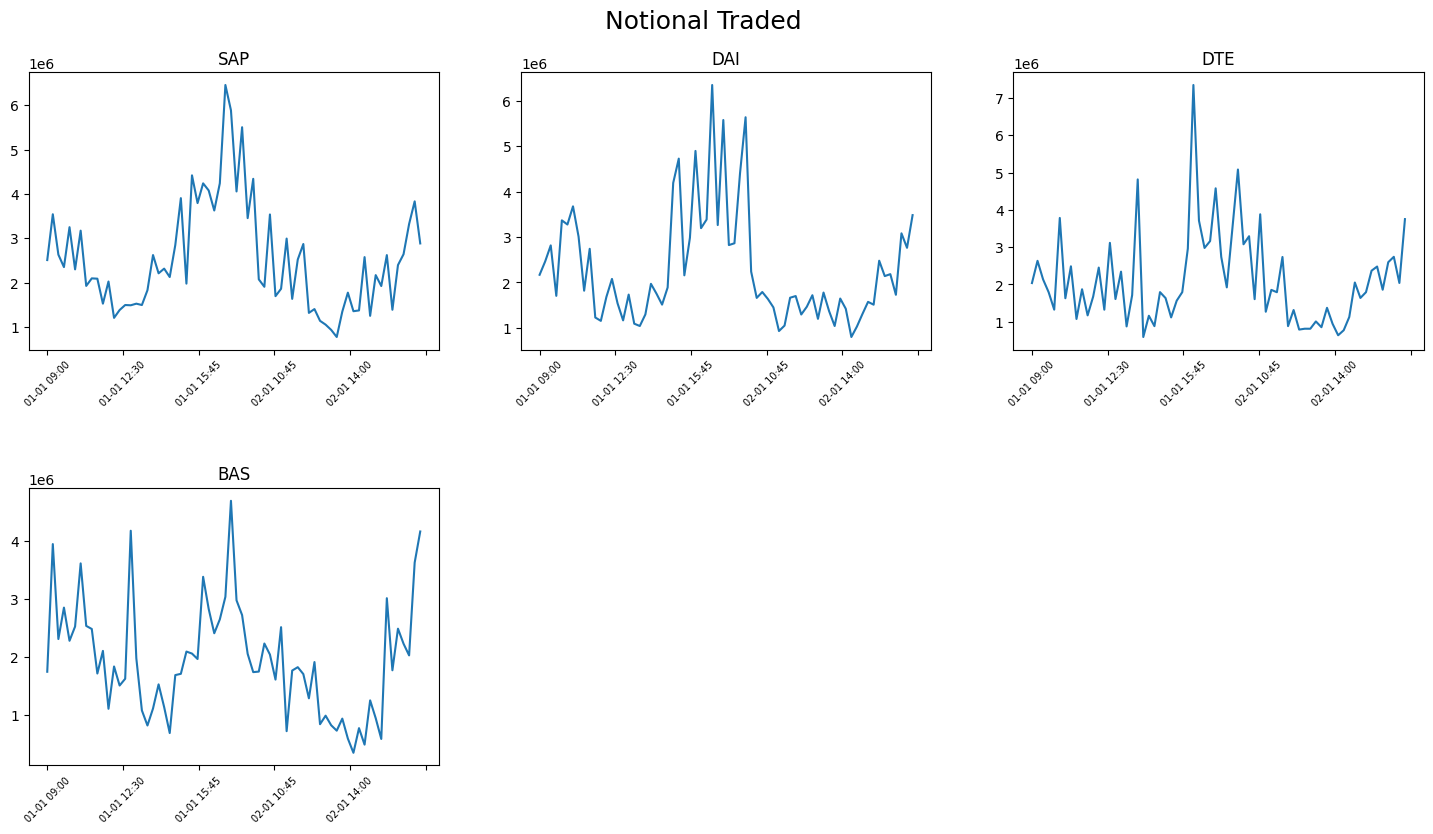

In [14]:
plt.figure(figsize=(18, 9))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Notional Traded", fontsize=18, y=0.95)
for n, stock_id in enumerate(df_stocks['stock_id']):
    agg=trade_aggregator(df_trades,stock_id,'15min',True)
    ax = plt.subplot(2, 3, n + 1)
    ax.plot(agg.reset_index().Hour, agg[0] ,label='DataFrame 1')
    ax.set_title(df_stocks.iloc[n,0])
    num_ticks = 6
    x_ticks = np.linspace(0,len(agg.Hour), num_ticks)
    plt.xticks(x_ticks,rotation=45, fontsize=7)
 
plt.show()

### <span style="color:#f1c232">Q6</span>

I used volume-weighted wages for each minute to better capture the price that the company exposed relatively more.

In [16]:
def ma_prep(df,ma,stock_id):
    df6=df.groupby(['stock_id','Time']).apply(lambda group: (group['PRICE'] * group['SIZE']).sum())/df_trades.groupby(['stock_id','Time'])['SIZE'].sum()
    df6=df6.loc[stock_id,:].rolling(ma).mean().dropna().reset_index()
    df6['hour']=df6.Time.str[:5]+df6.Time.str[10:16]
    df6=df6.set_index('Time')
    return df6

Moving Average(5) Plots:

Unknown Stock_id


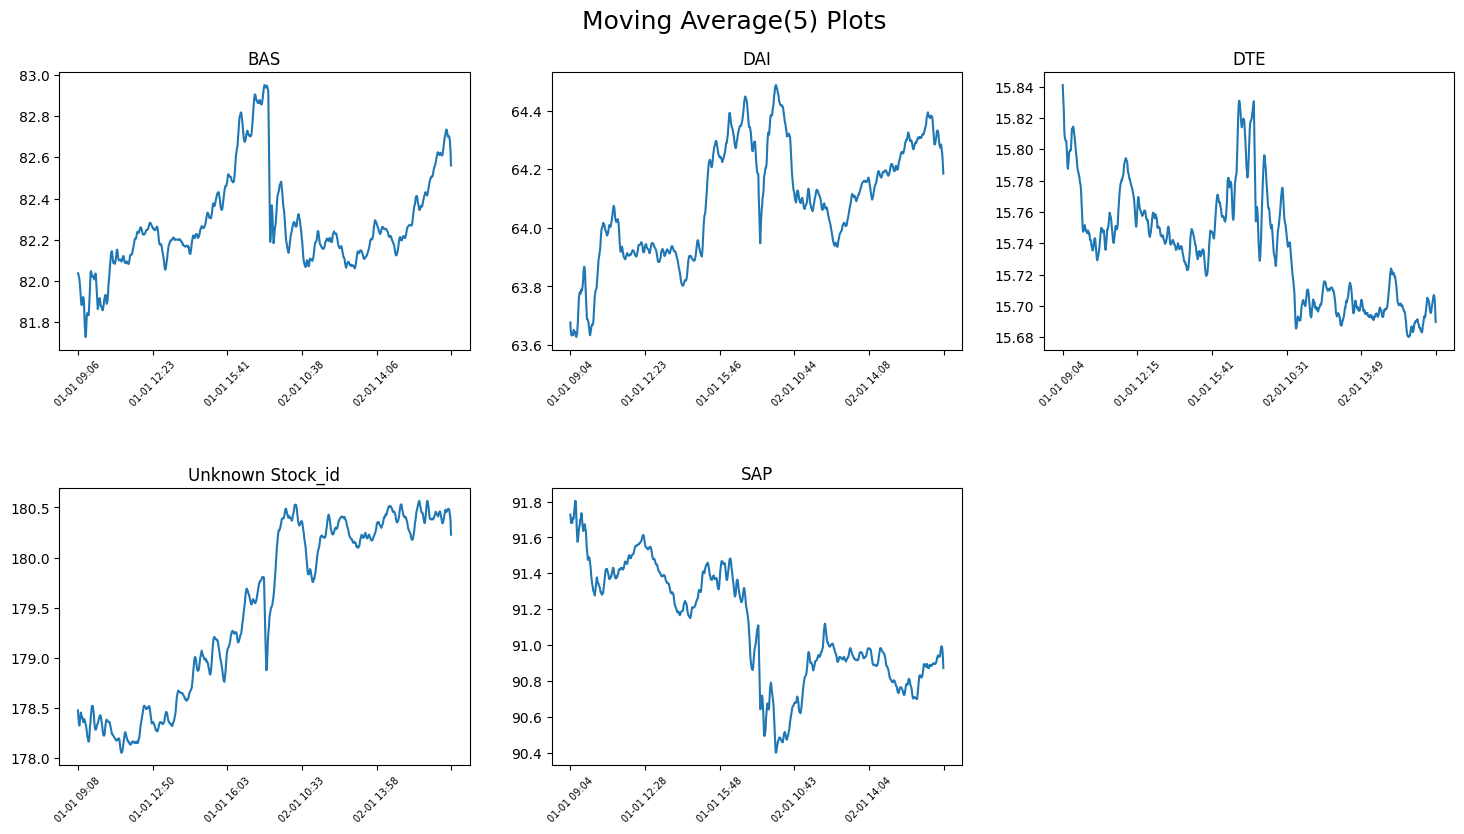

In [17]:
plt.figure(figsize=(18, 9))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Moving Average(5) Plots", fontsize=18, y=0.95)
for n, stock_id in enumerate(df_trades['stock_id'].unique()):
    ax = plt.subplot(2, 3, n + 1)
    df=ma_prep(df_trades,5,stock_id)
    ax.plot(df.reset_index().hour, df[0])
    try:
        ax.set_title(df_stocks['Stock'][stock_id])
    except Exception as e:
        print('Unknown Stock_id')
        ax.set_title('Unknown Stock_id')
    num_ticks = 6
    x_ticks = np.linspace(0,len(df[0]), num_ticks)
    plt.xticks(x_ticks,rotation=45, fontsize=7)
 
plt.show()

Top and Bottom 5 Moving Averages(5):

In [21]:
df_mas=ma_prep(df_trades,5,0)[0].nsmallest(5).reset_index().assign(stock_id=0,minmax='').iloc[0:0]
for i in df_trades.stock_id.unique():
    df=ma_prep(df_trades,5,i)
    df_mas=pd.concat([df_mas,df[0].nlargest(5).reset_index().assign(stock_id=i,minmax='max')], axis=0)
    df_mas=pd.concat([df_mas,df[0].nsmallest(5).reset_index().assign(stock_id=i,minmax='min')], axis=0)
df_mas=df_mas.reset_index().rename(columns={'index':'Rank',0:'Price'})
df_mas['Rank']=df_mas['Rank']+1
df_mas=df_mas.merge(df_stocks, how='outer' ,on='stock_id')
df_mas.pivot(index=['minmax','Rank'],values=['Price','Time'],columns='Stock')


Price                                               
Stock               NaN        BAS        DAI        DTE        SAP   
minmax Rank                                                           
max    1     180.566427  82.950428  64.487637  15.841094  91.804702  \
       2     180.566207  82.948146  64.485552  15.835094  91.802526   
       3     180.559598  82.947277  64.482979  15.831059  91.786462   
       4     180.555961  82.946433  64.482421  15.830643  91.764169   
       5     180.540486  82.946041  64.475656  15.830643  91.758413   
min    1     178.054964  81.728844  63.627278  15.680167  90.398714   
       2     178.065952  81.740584  63.629967   15.68036  90.402604   
       3     178.068356  81.749932  63.632324  15.680444  90.411891   
       4     178.075952  81.779195  63.632619  15.680941  90.417064   
       5     178.086134   81.79131  63.632853  15.680957  90.433513   

                         Time                                       
Stock                     NaN               BAS               DAI   
minmax Rank                                                         
max    1     02-01-2017 16:03  01-01-2017 17:19  02-01-2017 09:55  \
       2     02-01-2017 16:25  01-01-2017 17:20  02-01-2017 09:54   
       3     02-01-2017 16:01  01-01-2017 17:25  02-01-2017 09:53   
       4     02-01-2017 16:26  01-01-2017 17:21  02-01-2017 09:56   
       5     02-01-2017 16:23  01-01-2017 17:26  02-01-2017 09:52   
min    1     01-01-2017 11:15  01-01-2017 09:26  01-01-2017 09:20   
       2     01-01-2017 11:16  01-01-2017 09:27  01-01-2017 09:19   
       3     01-01-2017 11:14  01-01-2017 09:25  01-01-2017 09:18   
       4     01-01-2017 11:17  01-01-2017 09:24  01-01-2017 09:07   
       5     01-01-2017 11:12  01-01-2017 09:28  01-01-2017 09:11   

                                                 
Stock                     DTE               SAP  
minmax Rank                                      
max    1     01-01-2017 09:04  01-01-2017 09:20  
       2     01-01-2017 09:05  01-01-2017 09:21  
       3     01-01-2017 16:52  01-01-2017 09:19  
       4     01-01-2017 17:29  01-01-2017 09:18  
       5     01-01-2017 16:51  01-01-2017 09:22  
min    1     02-01-2017 16:17  02-01-2017 09:55  
       2     02-01-2017 16:16  02-01-2017 09:56  
       3     02-01-2017 16:13  02-01-2017 09:54  
       4     02-01-2017 16:12  02-01-2017 09:57  
       5     02-01-2017 16:18  02-01-2017 09:58

### <span style="color:#f1c232">Q7</span>

I calculated: the net changes of asset and cash, then net positions of asset and cash, then net notional asset position and lastly the net position.

In [37]:
def pl_calc(df,stock_id):
    df=df[df.stock_id==stock_id]
    df['dcash']=df['PRICE']*df['SIZE']*(-2*(df['BUY_SELL_FLAG'] -0.5))
    df['dasset']=df['SIZE']*(2*(df['BUY_SELL_FLAG'] -0.5))
    df['hour']=df['Time'].str[:5]+df['Time'].str[10:16]
    df['net cash']=df['dcash'].cumsum()
    df['net asset']=df['dasset'].cumsum()
    df['net notional asset']=df['net asset']*df['PRICE']
    df['net position']=df['net cash']+df['net notional asset']
    return df
pd.options.mode.chained_assignment = None  # default='warn'

Individual P/L's:
<br>
It looks like trades in DTE made the most profits followed by SAP and BAS while the other stocks made losts.

Unknown Stock_id


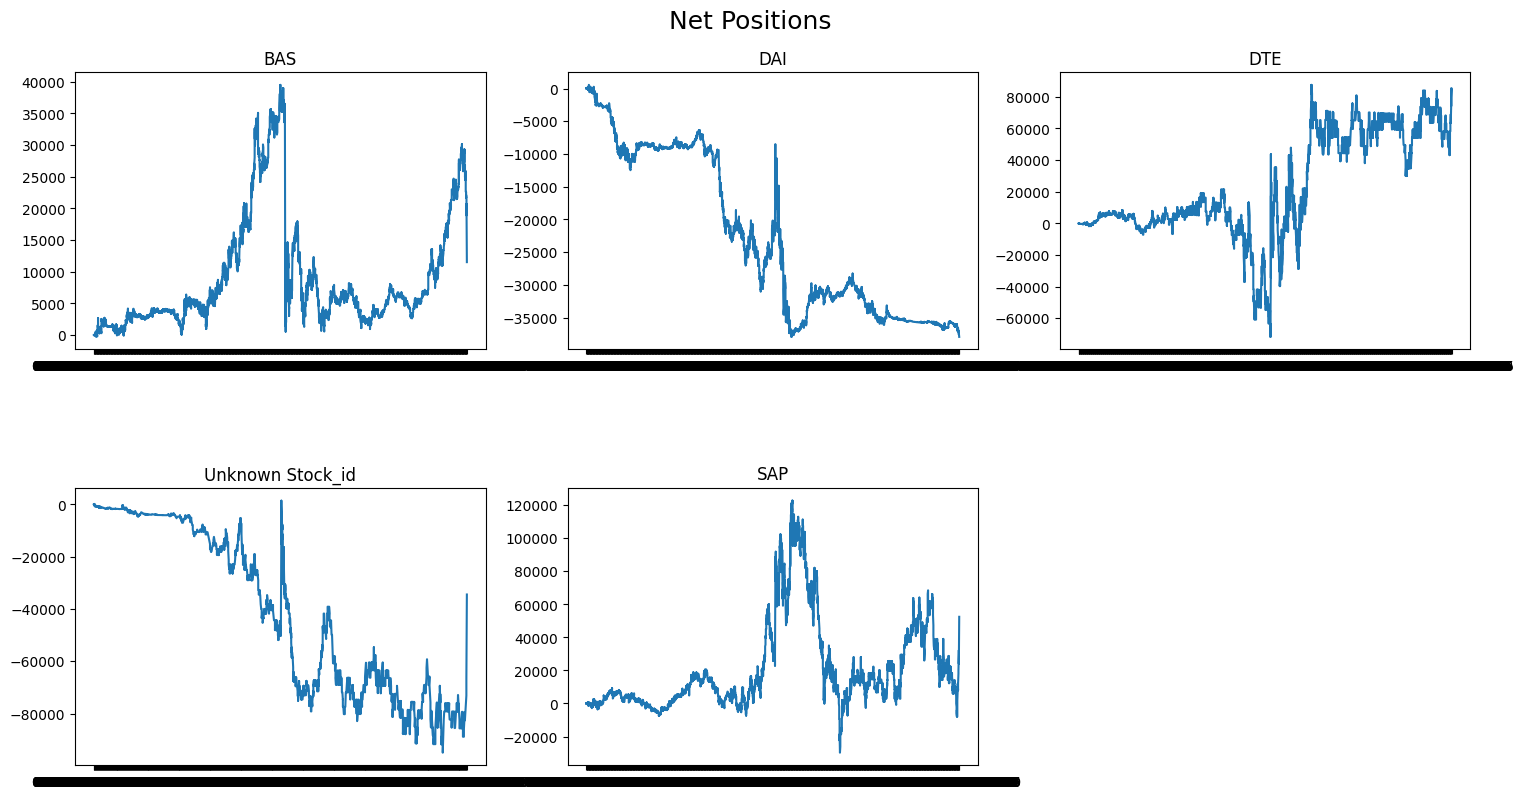

In [38]:
plt.figure(figsize=(18, 9))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Net Positions", fontsize=18, y=0.95)
for n, stock_id in enumerate(df_trades['stock_id'].unique()):
    ax = plt.subplot(2, 3, n + 1)
    df=pl_calc(df_trades,stock_id)
    ax.plot(df.Time, df['net position'])
    try:
        ax.set_title(df_stocks['Stock'][stock_id])
    except Exception as e:
        print('Unknown Stock_id')
        ax.set_title('Unknown Stock_id')
    #num_ticks = 6
    #x_ticks = np.linspace(0,len(df), num_ticks)
    #plt.xticks(x_ticks,rotation=45, fontsize=7)
 
plt.show()

Portfolio P/L's:
<br>


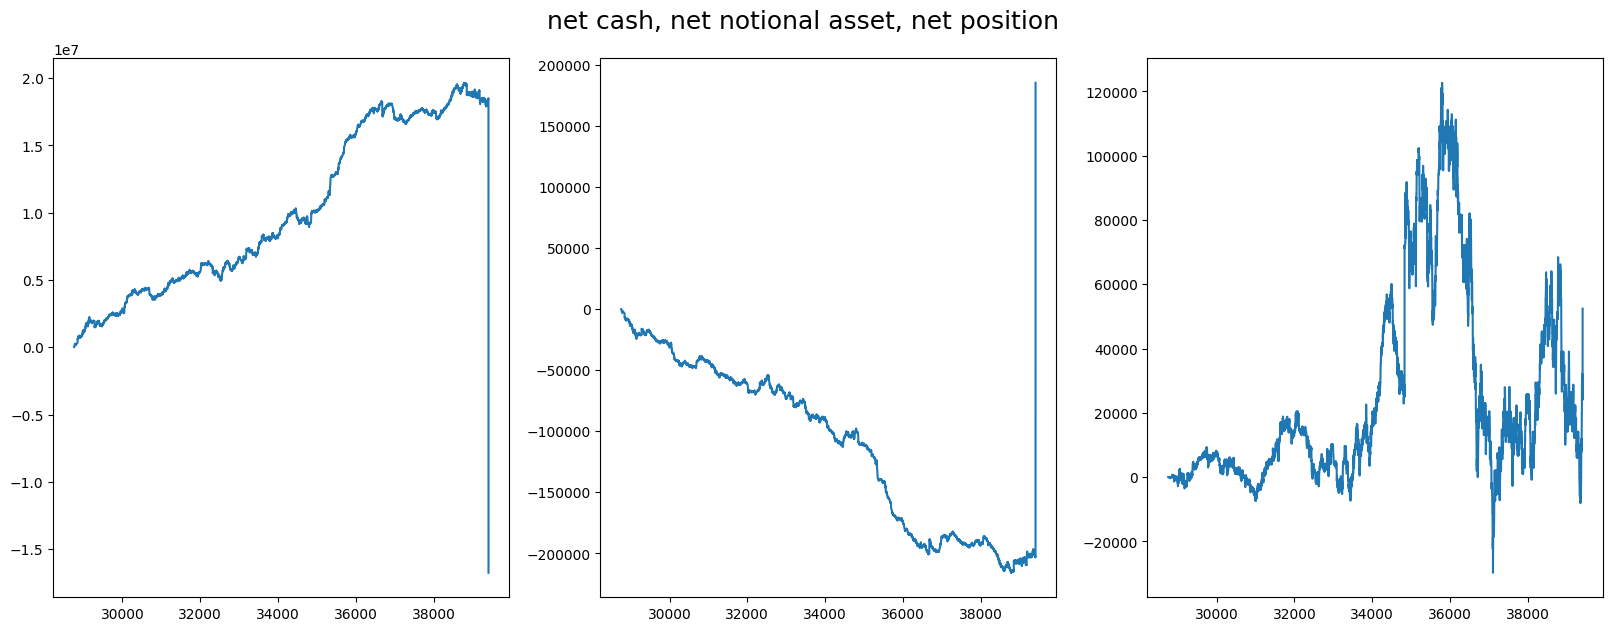

In [39]:
plt.figure(figsize=(20, 7))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("net cash, net notional asset, net position", fontsize=18, y=0.95)

df8=pl_calc(df_trades,stock_id).iloc[0:0]
for n in df_trades['stock_id'].unique():
    df8=pd.concat([df8,pl_calc(df_trades,n)],axis=0)
df8.groupby(['Time'])[['net cash','net asset','net notional asset','net position']].sum()

ax = plt.subplot(1, 3, 1).plot(df.index, df['net cash'])
ax = plt.subplot(1, 3, 2).plot(df.index, df['net asset'])
ax = plt.subplot(1, 3, 3).plot(df.index, df['net position'])

 
plt.show()


This time I keep the outliers in the last trade (probably from BAS, SAP and/or Unknown_id) as they distort the figure less in the contrary the last trade is informative this time (potentially closing positions). 